# Load Dataset

In [59]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [61]:
df = pd.read_csv('train.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2,-56,-0.33,-0.09,0.90,0.2,-11,12,0.004,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.9,0.032,-0.0009
1,470,-39,0.02,0.12,0.39,-0.6,-12,8,0.009,-1.6,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.9,0.034,-0.0011
2,165,4,0.14,0.14,0.78,0.4,-11,-9,-0.003,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,1.0,0.034,-0.0012
3,-113,5,-0.12,0.11,1.06,0.6,-10,-7,-0.008,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.9,0.033,-0.0011
4,-411,-21,-0.17,0.07,1.33,-0.6,-11,0,0.002,0.1,...,0.0,0.0,0.0,0.0,0.0,-0.002,0.0,0.9,0.032,-0.0008


# Data Process

In [62]:
def datasetSplit(dataset, frac, random_state):
    # 采用随机取样
    # 设置 random_state 是为了确保每次抽样都能得到相同的随机样本
    dataset_train = dataset.sample(frac=frac, random_state=random_state)
    dataset_test = dataset[~dataset.index.isin(dataset_train.index)]
    X_train = dataset_train.iloc[:,:40]
    Y_train = dataset_train[40]
    X_test = dataset_test.iloc[:,:40]
    Y_test = dataset_test[40]
    return X_train, Y_train, X_test, Y_test

# Model

In [63]:
class Tree:
    def __init__(self, feature, f_value):
        self.feature = feature
        self.f_value = f_value
        self.left_tree = None
        self.right_tree = None


class ReregssionTree:
    def __init__(self, gamma, lambda0, max_depth, gain_threshold=None, tree_threshold=None):
        self.gamma = gamma
        self.lambda0 = lambda0
        self.max_depth = max_depth
        self.gain_threshold = gain_threshold
        self.tree_threshold = tree_threshold
        self.root = None

    def getBestSplit(self, train_X, train_y, pred_y, depth):
        if depth >= self.max_depth:
            return None, self.getLeafWeight(train_y, pred_y)
        if len(set(train_y.T.tolist())) == 1:
            return None, self.getLeafWeight(train_y, pred_y)

        if self.tree_threshold is not None and len(set(train_y.T.tolist())) <= self.tree_threshold:
            return None, self.getLeafWeight(train_y, pred_y)

        nums, features = np.shape(train_X)
        max_gain = float("-inf")
        obj1 = self.Obj(train_y, pred_y)
        best_feature, best_f_value = 0, 0
        for feature in range(features):
            f_values_list = set(train_X[:, feature].T.tolist())
            for f_value in f_values_list:
                split_train_X, split_train_y, split_pred_y = self.splitTree(train_X, train_y, pred_y, feature, f_value)
                obj2 = self.Obj(split_train_y[0], split_pred_y[0]) + self.Obj(split_train_y[1], split_pred_y[1])
                gain = obj1 - obj2
                if gain > max_gain:
                    max_gain = gain
                    best_feature = feature
                    best_f_value = f_value
        if self.gain_threshold is not None and max_gain <= self.gain_threshold:
            return None, self.getLeafWeight(train_y, pred_y)
        return best_feature, best_f_value

    def splitTree(self, train_X, train_y, pred_y, feature, f_value):
        left = np.nonzero(train_X[:, feature] <= f_value)[0]
        right = np.nonzero(train_X[:, feature] > f_value)[0]
        l_train_X = train_X[left, :]
        r_train_X = train_X[right, :]
        l_train_y = train_y[left]
        r_train_y = train_y[right]
        l_pred_y = pred_y[left]
        r_pred_y = pred_y[right]
        return (l_train_X, r_train_X), (l_train_y, r_train_y), (l_pred_y, r_pred_y)

    def Obj(self, train_y, pred_y):
        G = np.sum(-2 * (train_y - pred_y))
        H = 2 * train_y.shape[0]
        obj = -0.5 * (G ** 2) / (H + self.lambda0) + self.gamma
        return obj

    def buildTree(self, train_X, train_y, pred_y, depth):
        feature, f_value = self.getBestSplit(train_X, train_y, pred_y, depth)
        if feature is None:
            return Tree(feature, f_value)
        tree = Tree(feature, f_value)
        split_train_X, split_train_y, split_pred_y = self.splitTree(train_X, train_y, pred_y, feature, f_value)

        tree.left_tree = self.buildTree(split_train_X[0], split_train_y[0], split_pred_y[0], depth + 1)
        tree.right_tree = self.buildTree(split_train_X[1], split_train_y[1], split_pred_y[1], depth + 1)
        return tree

    def getLeafWeight(self, train_y, pred_y):
        G = np.sum(-2 * (train_y - pred_y))
        H = 2 * train_y.shape[0]
        weight = - G / (H + self.lambda0)
        return weight

    def fit(self, train_X, train_y, pred_y):
        self.root = self.buildTree(train_X, train_y, pred_y, 0)

    def predict(self, X):
        node = self.root
        while node.feature is not None:
            if X[node.feature] <= node.f_value:
                node = node.left_tree
            else:
                node = node.right_tree
        return node.f_value


class XGBoost:
    def __init__(self, model_num, gamma, lambda0, max_depth, gain_threshold=None, tree_threshold=None):
        self.model_num = model_num
        self.gamma = gamma
        self.lambda0 = lambda0
        self.max_depth = max_depth
        self.gain_threshold = gain_threshold
        self.tree_threshold = tree_threshold
        self.model_lists = []
        self.rmses = []
        self.r2s = []
        
    def fit(self, train_X, train_y, pred_y):
        nums, features = train_X.shape
        for _ in range(self.model_num):
            base_model = ReregssionTree(self.gamma, self.lambda0, self.max_depth, self.gain_threshold, self.tree_threshold)
            base_model.fit(train_X, train_y, pred_y)
            self.model_lists.append(base_model)
            for i in range(nums):
                pred_y[i] += base_model.predict(train_X[i, :])
            rmse = np.sqrt(np.sum(np.square(train_y - pred_y)) / nums)
            r2 = 1 - np.square(rmse) / np.var(train_y)
            self.rmses.append(rmse)
            self.r2s.append(r2)
    
    def predict(self, X):
        pred_y = np.zeros((X.shape[0]))
        for num in range(self.model_num):
            for i in range(X.shape[0]):
                pred_y[i] += self.model_lists[num].predict(X[i, :])
        return pred_y

# Train

In [64]:
X_train, Y_train, X_test, Y_test = datasetSplit(df, 0.8, 3407)
X_train, Y_train, X_test, Y_test = np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)
pred_y = np.zeros((np.shape(X_train)[0]))
xgb_model = XGBoost(10, 1e-2, 1e-2, 4, None, None)

In [65]:
start_time = time.time()
xgb_model.fit(X_train, Y_train, pred_y)
end_time = time.time()
print("training time is {} s".format(end_time - start_time))

training time is 76.43791794776917 s


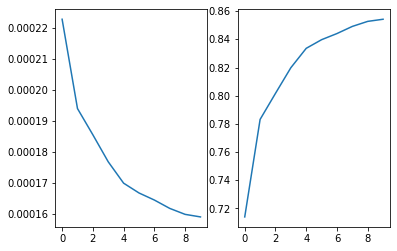

In [66]:
plt.subplot(1, 2, 1)
plt.plot(xgb_model.rmses)
plt.subplot(1, 2, 2)
plt.plot(xgb_model.r2s)

更改 `gain_threshold` 参数

In [87]:
X_train1, Y_train1, X_test, Y_test = datasetSplit(df, 0.8, 3407)
X_train1, Y_train1, X_test, Y_test = np.array(X_train1), np.array(Y_train1), np.array(X_test), np.array(Y_test)
pred_y1 = np.zeros((np.shape(X_train1)[0]))
xgb_model1 = XGBoost(10, 1e-5, 1e-5, 4, 0, None)
start_time = time.time()
xgb_model1.fit(X_train1, Y_train1, pred_y1)
end_time = time.time()
print("training time is {} s".format(end_time - start_time))

training time is 34.12798523902893 s


更改 `tree_threshold` 参数

In [68]:
X_train2, Y_train2, X_test, Y_test = datasetSplit(df, 0.8, 3407)
X_train2, Y_train2, X_test, Y_test = np.array(X_train2), np.array(Y_train2), np.array(X_test), np.array(Y_test)
pred_y2 = np.zeros((np.shape(X_train2)[0]))
xgb_model2 = XGBoost(10, 1e-2, 1e-2, 4, None, 20)
start_time = time.time()
xgb_model2.fit(X_train2, Y_train2, pred_y2)
end_time = time.time()
print("training time is {} s".format(end_time - start_time))

training time is 65.62508726119995 s


更改 $\gamma$ 和 $\lambda$ 参数

In [69]:
X_train3, Y_train3, X_test, Y_test = datasetSplit(df, 0.8, 3407)
X_train3, Y_train3, X_test, Y_test = np.array(X_train3), np.array(Y_train3), np.array(X_test), np.array(Y_test)
pred_y3 = np.zeros((np.shape(X_train3)[0]))
xgb_model3 = XGBoost(10, 1e-5, 1e-5, 4, None, None)
start_time = time.time()
xgb_model3.fit(X_train3, Y_train3, pred_y3)
end_time = time.time()
print("training time is {} s".format(end_time - start_time))

training time is 72.97378540039062 s


更改 `max_depth` 参数

In [70]:
X_train4, Y_train4, X_test, Y_test = datasetSplit(df, 0.8, 3407)
X_train4, Y_train4, X_test, Y_test = np.array(X_train4), np.array(Y_train4), np.array(X_test), np.array(Y_test)
pred_y4 = np.zeros((np.shape(X_train4)[0]))
xgb_model4 = XGBoost(10, 1e-2, 1e-2, 3, None, None)
start_time = time.time()
xgb_model4.fit(X_train4, Y_train4, pred_y4)
end_time = time.time()
print("training time is {} s".format(end_time - start_time))

training time is 54.02429151535034 s


更改回归树学习的个数 `model_num`

In [90]:
X_train5, Y_train5, X_test, Y_test = datasetSplit(df, 0.8, 3407)
X_train5, Y_train5, X_test, Y_test = np.array(X_train5), np.array(Y_train5), np.array(X_test), np.array(Y_test)
pred_y5 = np.zeros((np.shape(X_train5)[0]))
xgb_model5 = XGBoost(5, 1e-2, 1e-2, 4, None, None)
start_time = time.time()
xgb_model5.fit(X_train5, Y_train5, pred_y5)
end_time = time.time()
print("training time is {} s".format(end_time - start_time))

training time is 36.53042960166931 s


绘制上述的 RMSE 曲线图

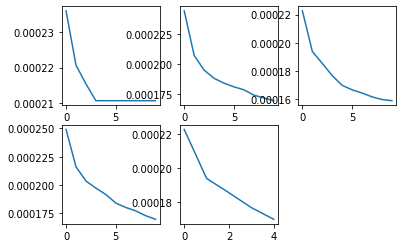

In [91]:
plt.subplot(2, 3, 1)
plt.plot(xgb_model1.rmses)
plt.subplot(2, 3, 2)
plt.plot(xgb_model2.rmses)
plt.subplot(2, 3, 3)
plt.plot(xgb_model3.rmses)
plt.subplot(2, 3, 4)
plt.plot(xgb_model4.rmses)
plt.subplot(2, 3, 5)
plt.plot(xgb_model5.rmses)

# Test

In [73]:
pred = xgb_model.predict(X_test)
rmse = np.sqrt(np.sum(np.square(Y_test - pred)) / Y_test.shape[0])
print("rmse of predict result is {}".format(rmse))
r2 = 1 - np.square(rmse) / np.var(Y_test)
print("r2 of predict result is {}".format(r2))

rmse of predict result is 0.0001795749308590117
r2 of predict result is 0.7930288898270818


更改 `gain_threshold` 参数后的评价指标

In [89]:
pred = xgb_model1.predict(X_test)
rmse = np.sqrt(np.sum(np.square(Y_test - pred)) / Y_test.shape[0])
print("rmse of predict result is {}".format(rmse))
r2 = 1 - np.square(rmse) / np.var(Y_test)
print("r2 of predict result is {}".format(r2))

rmse of predict result is 0.00020758498950218342
r2 of predict result is 0.7234267288920804


更改 `tree_threshold` 参数后的评价指标

In [75]:
pred = xgb_model2.predict(X_test)
rmse = np.sqrt(np.sum(np.square(Y_test - pred)) / Y_test.shape[0])
print("rmse of predict result is {}".format(rmse))
r2 = 1 - np.square(rmse) / np.var(Y_test)
print("r2 of predict result is {}".format(r2))

rmse of predict result is 0.00018717952490685468
r2 of predict result is 0.7751282008186492


更改 $\gamma$ 和 $\lambda$ 参数后的评价指标

In [76]:
pred = xgb_model3.predict(X_test)
rmse = np.sqrt(np.sum(np.square(Y_test - pred)) / Y_test.shape[0])
print("rmse of predict result is {}".format(rmse))
r2 = 1 - np.square(rmse) / np.var(Y_test)
print("r2 of predict result is {}".format(r2))

rmse of predict result is 0.00017963471450946426
r2 of predict result is 0.7928910582475729


更改 `max_depth` 参数后的评价指标

In [77]:
pred = xgb_model4.predict(X_test)
rmse = np.sqrt(np.sum(np.square(Y_test - pred)) / Y_test.shape[0])
print("rmse of predict result is {}".format(rmse))
r2 = 1 - np.square(rmse) / np.var(Y_test)
print("r2 of predict result is {}".format(r2))

rmse of predict result is 0.0001862837443594758
r2 of predict result is 0.7772753777630352


更改回归树学习的个数 `model_num` 后的评价指标

In [92]:
pred = xgb_model5.predict(X_test)
rmse = np.sqrt(np.sum(np.square(Y_test - pred)) / Y_test.shape[0])
print("rmse of predict result is {}".format(rmse))
r2 = 1 - np.square(rmse) / np.var(Y_test)
print("r2 of predict result is {}".format(r2))

rmse of predict result is 0.0001805729061963554
r2 of predict result is 0.7907220420732954


使用 `XGBoost` 官方库进行训练，并且对比预测结果

In [93]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test)
params = {'booster':'gbtree',
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth':4,
        'lambda':1e-6,
        'gamma':1e-6}
start_time = time.time()
bst = xgb.train(params, dtrain, num_boost_round=100)
end_time = time.time()
print("training time is {} s".format(end_time - start_time))
ypred=bst.predict(dtest)

training time is 0.3104684352874756 s


In [94]:
rmse = np.sqrt(np.sum(np.square(Y_test - ypred)) / Y_test.shape[0])
print(rmse)
r2 = 1 - np.square(rmse) / np.var(Y_test)
print(r2)

0.00016648923614338208
0.82209398373161
